# Linear Classification

Reviewing some linear classification concepts. Here, I will use linear classification on the CIFAR-10 images. 

### Predicting classes

Our linear classifier looks as follows:

$$f(x_i, Wb) = Wx_i + b$$

where $x_i$ are our inputs (images) and W the weights and b the biases.


### Note on matrix shape

Note that the CIFAR-10 has 10 classes. Therefore, for a given image, our function should give the probabilities that it belongs to each of these categories. 

Note that these images will be flatten. 

In [371]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
%matplotlib inline

In [372]:
## Get One batch of CFAR 10 data set

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [373]:
data = load_cfar10_batch('../Udacity/deep_learning/projects/image-classification/cifar-10-batches-py',
                 1)

In [374]:
features = data[0]
labels = data[1]

In [375]:
def image_standarization(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x_demean = x - np.mean(x)
    adjusted_sd = np.maximum(np.std(x), 1.0/np.sqrt(np.prod(x.shape)))
    return  x_demean / adjusted_sd


In [376]:
features = np.array([image_standarization(i) for i in features])

### Flattening one Image and going through one of these classifications

Here, I will use one image as an example to understand how the matrix multiplication works and how, in the end, we have as output 10 classes.

Note that our image has 32, 32, 3 shape. This means it has 32x32 pixels and and red, green, blue channels. As a first step, we flatten this image, resulting in a 1*3072 array.

Note that we need to have corresponding weights for each of the pixels. That means that our weights matrix needs to have 3072 rows, one weight per each pixel and 10 columns, one per each classs. On top, we add a bias per class, that is, we add 10 bias. 

<img src="img/linear_class/matrix_mult_linear.png" width="900px">




In [377]:
#Flattening the image
first_image = features[0]
flatten_first = first_image.flatten()

In [378]:
## Creating randomly our weights 
weights_matrix = np.random.standard_normal((3072, 10))
bias = np.zeros(10)
#Performing the dot product
matrix_multiply = np.dot(flatten_first, weights_matrix) + bias

Once we have our weights, outputs and images, we perform the dot product between the image and weights. This gives us a 1*10 array to which we then add the biases. In the end we have a 10 array which represents the "scores" given to each of the classes. We have reduced our 3072 array to a 10 array output thanks to our weights. 

However, we don't simply want to reduce the dimmensionality of our picture. We want to make sure than when we receive an image as an input, the right category is selected. This means that we need to train our weights to correctly perform such classification.

In [379]:
#Normalization trick for numerical stability
matrix_multiply -= np.max(matrix_multiply)
# Applying Softmax to our reduced dimension matrix
soft_max = np.exp(matrix_multiply) / np.sum(np.exp(matrix_multiply))
soft_max[np.argmax(labels[0])]

5.9467491471520559e-22

## Evaluating our Weights

Once we have perform this matrix multiplication, and push it through a softmax function, is evaluation time. The label that our weights predict, would be the class that has the biggest probability.

According to our results, this corresponds to the automobile label. However, the true label corresponds to an airplane. Why the mistake? Simple, our linear classifier has yet to learn. It has started with random weights, therefore, the output will also be random. Here is where the *learning* part of machine learning starts.

In [380]:
pred_label = np.argmax(soft_max)

In [381]:
labels_names = 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
labels_dict = dict(enumerate(labels_names))

In [382]:
labels_dict[pred_label]

'truck'

In [383]:
labels_dict[labels[0]]

'frog'

## Learning Weights

We need to come up with a way of telling our algorithm that it is wrong to classify an airplane as a car. This is where loss functions come into play. Loss functions will measure how much off is our algorithm from the real labels. Loss functions will increase the more difference between predictions and algorithms. The objective is to reduce the loss function. Is from this process of trial and error that our algorithm learns better weights.

The loss function for the softmax has the following form:

$$L_i = -log \Big(\frac{e^{f_{y_i}}}{\sum_je^{f_j}}\Big)$$

Note that $i$ refers to the correct class. In this case we want to increase our loss function in relation with how well it does at classifying the true label.

Let's put an example: suppose we have only three classes to classify: "car", "pen", "house". 

<img src="img/linear_class/softmax.png" width="750px">

In the figure we show the effect after our images have gone through the weights and a softmax function has been applied. As shown, even if the car is the correct label, it only gets a probability of 0.1. Correspondingly, we calculate the loss for this example:

In [384]:
#Example Loss
ex_softmax = np.array([0.1, 0.5, 0.4])
true_label = [1, 0, 0]
#Getting the calculated softmax for correct label
i_loss = np.dot(ex_softmax, true_label)
loss = -np.log(i_loss)
loss

2.3025850929940455

As the calculation reflects, our loss increases, because our prediction is incorrect. It is interesting to show how the softmax changes due to changes in the probability assigned to the right label. To start with, it is important to notice that a logarithm of a small number will be big, the smaller the number, the bigger the result. On the other extreme, $log(1) = 0$. This calculation goes with our intuition. It says, when the right label has a small probability, then you need to add to the loss. On the other hand when there is a probability of 1 on the correct label, there is no need to add to the loss, because the classifier has it right.

Here is a graph for our example on how the loss changes given the probabilities assigned to the right label.

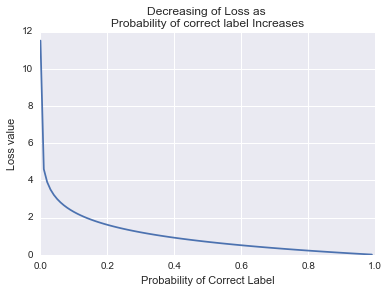

In [385]:
#Generating different probabilities for correct label
y = np.arange(0.00001, 1, 0.01)
sim = -np.log(np.arange(0.00001, 1, 0.01))
fig, ax = plt.subplots()
ax.plot(y, sim);
ax.set_title("Decreasing of Loss as \nProbability of correct label Increases")
ax.set_ylabel("Loss value")
ax.set_xlabel("Probability of Correct Label");

The loss is important because it will guide us in our objective. In particular, we want to make the loss as small as possible. However, what steps do we need to take to make sure we are decreasing the loss. After all, there is a bunch of weights that can be consider. How to make sure we are actually going in the direction of minimizing the loss? 

Here is where calculus kicks in. Finding the gradient of the loss with respect to the weights makes sure that everytime we update our weights we are doing it in the direction that minimizes the loss function. 

In [386]:
# Updating weights after one gradient descent for first image
#One hot encoding labels
image_cat = list(range(0,10))
encoder = LabelBinarizer()
encoder.fit(image_cat)
labels = encoder.transform(labels)

In [387]:
#For one pass
#Getting softmax of correct label
soft_max[np.argmax(labels[0])] -= 1
dsoft = soft_max
dW = np.outer(flatten_first, dsoft)
db = np.sum(dsoft, axis=0, keepdims=True)
weights_matrix -= 0.5 * dW
bias[0] -= 0.5 *db

Let's see the changes for our example for one pass

In [388]:
matrix_multiply = np.dot(flatten_first, weights_matrix) + bias
matrix_multiply -= np.max(matrix_multiply)
soft_max = np.exp(matrix_multiply) / np.sum(np.exp(matrix_multiply))
soft_max[np.argmax(labels[0])]

1.0

Our calculations for this image made the weights to properly predict the label. The story is more complicated when more image and labels are to be trained. In this case, there is a lot of trade-offs to be done, and our classifier is bound to make some mistakes. Let's do three things: 
1. Split our data set in training/validation/testing.
2. Train our weights with our training data and then check validation error.
3. Test our parameters on test data.

In [389]:
#Flattening all images
features = features.reshape(10000, 32*32*3)

In [390]:
image, image_test, y, y_test = train_test_split(features,labels,test_size=0.2,train_size=0.8)
image_train, image_val, y_train, y_val = train_test_split(image, y,test_size = 0.25,train_size =0.75)

In [405]:
def score(features, weights):
    matrix_multiply = np.dot(features, weights) + bias
    exp = np.exp(matrix_multiply) 
    soft_max = exp / np.sum(exp, axis=1, keepdims=True)
    return soft_max
    

In [421]:
## Algorithm
epochs = 200
n_training = len(image_train)
step_size = 0.001

#Initializing weights and biases
weights_matrix = 0.0001*np.random.standard_normal((3072, 10))
bias = np.zeros((1,10))
#Performing the dot product

for i in range(epochs):
    
    #Perform dot product 
    soft_max = score(image_train, weights_matrix)


    #Calculating Loss
    correct_labels_prob = soft_max[range(n_training), np.argmax(y_train, axis=1)]
    loss = np.sum(-np.log(correct_labels_prob)) / n_training
    
    
    #Calculating gradient
    g_probs = np.copy(soft_max)
    g_probs[range(n_training), np.argmax(y_train, axis=1)] -= 1
    
    #Get the average of the gradients
    g_probs = g_probs / n_training
    
    dW = np.dot(image_train.T, g_probs)
    db = np.sum(g_probs, axis=0, keepdims=True)
    
    # perform a parameter update
    weights_matrix += -step_size * dW
    bias += -step_size * db
    
    if i%5:
        print("Loss: {}".format(loss))

    # evaluate training set accuracy
    preds_score = score(image_val, weights_matrix)
    pred_ones = np.zeros_like(preds_score) #generates zero matrix to populate them with ones to then make comparisons
    pred_ones[np.arange(len(preds_score)), preds_score.argmax(1)] = 1
    accuracy = np.mean(pred_ones == y_val)

    if i%5:
        print("Validation Accuracy: {}".format(accuracy))

Loss: 2.2846163888484794
Validation Accuracy: 0.8563
Loss: 2.2674336269140962
Validation Accuracy: 0.8568
Loss: 2.251447491862663
Validation Accuracy: 0.8569
Loss: 2.236556120632148
Validation Accuracy: 0.8574
Loss: 2.2096901380587832
Validation Accuracy: 0.8577
Loss: 2.1975507158152436
Validation Accuracy: 0.8576
Loss: 2.18617560615842
Validation Accuracy: 0.8576
Loss: 2.1754994254573985
Validation Accuracy: 0.8576
Loss: 2.1560116449626188
Validation Accuracy: 0.8583
Loss: 2.1470971949402267
Validation Accuracy: 0.8584
Loss: 2.138675071056721
Validation Accuracy: 0.8587
Loss: 2.1307051110346933
Validation Accuracy: 0.8591
Loss: 2.115979569487773
Validation Accuracy: 0.8594
Loss: 2.1091611498544176
Validation Accuracy: 0.8596
Loss: 2.1026685849994236
Validation Accuracy: 0.8593
Loss: 2.09647729870283
Validation Accuracy: 0.8599
Loss: 2.084911341633739
Validation Accuracy: 0.8607
Loss: 2.079497948569199
Validation Accuracy: 0.8611
Loss: 2.0743080029727183
Validation Accuracy: 0.8615
Los

## References

[Notes from Stanford's CNN's for visual recognition](http://cs231n.github.io/neural-networks-case-study/)

[Deriving the softmax loss](https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function)